In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import math
from tqdm import tqdm
import requests
from urllib.parse import urlparse
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
import datetime
from sklearn.preprocessing import quantile_transform
pd.options.mode.chained_assignment = None  # default='warn'
import gc
import matplotlib
matplotlib.rcParams['axes.unicode_minus'] = False
font_path = './NanumFontSetup_TTF_BARUNGOTHIC/NanumBarunGothic.ttf'
import matplotlib.font_manager as fm
fontprop = fm.FontProperties(fname=font_path, size=18)
import seaborn as sns
import shap

In [2]:
%%time
# Read Data
basedir = './Training/training_data_ver_16/'
training_data_df = pd.read_csv(basedir + 'training_data_ver_16.csv').drop(columns=['주택가격지수']).dropna()
#training_data_df = training_data_df[(training_data_df['가격면적'] >= 200) & (training_data_df['가격면적'] <= 1500)]
training_data_df.columns = [col.replace(' ','_').replace('·','_') for col in training_data_df.columns]

Wall time: 1min 23s


In [3]:
training_data_df = training_data_df[(training_data_df['가격면적'] >= 200) & (training_data_df['가격면적'] <= 3000)]

In [4]:
training_data_df['호수대비부속건축물면적'] = training_data_df['부속건축물면적'] / training_data_df['총호수']

In [5]:
training_data_df = training_data_df[(training_data_df['호수대비부속건축물면적'] < 100)]

In [6]:
training_data_df = training_data_df.reset_index(drop=True)

In [7]:
cols_to_log = ['총건축면적', '총연면적', '총용적률연면적', '토지면적', '부속건축물면적']
for col in cols_to_log:
    training_data_df[col] = training_data_df[col].apply(np.log1p)

In [8]:
cat_cols_df = pd.read_csv(basedir + 'cat_cols.csv')

In [9]:
cat_cols_list = [col.replace(' ','_').replace('·','_') for col in cat_cols_df['colname'].tolist()]
len(cat_cols_list)

296

In [10]:
cat_cols = [col for col in training_data_df.columns if col in cat_cols_list]
len(cat_cols)

296

In [11]:
cat_cols[:10]

['건물나이',
 'trade_type',
 '표준지여부',
 '지목명',
 '용도지역명1',
 '용도지역명2',
 '토지이동상황',
 '지형높이',
 '지형형상',
 '도로접면']

In [12]:
shap_summary_df = pd.read_csv(basedir + 'shap_top_46.csv', index_col=[0]).sort_values(['shap_summary_mean'], ascending=False)
print(shap_summary_df.shape)
shap_summary_df.head()

(46, 6)


,model_0_shap_summary,model_1_shap_summary,model_2_shap_summary,model_3_shap_summary,model_4_shap_summary,shap_summary_mean
trade_type,92.672444,93.414445,90.729161,92.157627,90.401479,91.875031
공시지가(만원),73.609808,74.851469,77.544954,76.748606,74.751322,75.501232
year_linear,63.356944,64.540468,65.931529,66.177450,64.132569,64.827792
건축년도,49.787690,48.301946,51.157407,49.175005,47.597789,49.203968
전용면적,41.056895,40.254464,41.775569,40.587287,38.570764,40.448996


In [13]:
shap_summary_df.tail(50)

,model_0_shap_summary,model_1_shap_summary,model_2_shap_summary,model_3_shap_summary,model_4_shap_summary,shap_summary_mean
trade_type,92.672444,93.414445,90.729161,92.157627,90.401479,91.875031
공시지가(만원),73.609808,74.851469,77.544954,76.748606,74.751322,75.501232
year_linear,63.356944,64.540468,65.931529,66.177450,64.132569,64.827792
건축년도,49.787690,48.301946,51.157407,49.175005,47.597789,49.203968
전용면적,41.056895,40.254464,41.775569,40.587287,38.570764,40.448996
ynorm,30.941145,30.879359,33.024696,31.911765,29.596766,31.270746
xy,21.277371,21.582534,21.386985,21.636490,22.595563,21.695789
x_2nd,18.741818,18.948716,19.337666,18.192377,19.142350,18.872585
주건축물수,11.876253,14.045022,13.256153,13.657870,12.897278,13.146515
층mean,9.727066,10.365645,10.973181,10.651070,11.576581,10.658709


In [14]:
top_45_df = shap_summary_df.iloc[:45,:]
print(top_45_df.shape)

(45, 6)


In [15]:
top_45_df.head()

,model_0_shap_summary,model_1_shap_summary,model_2_shap_summary,model_3_shap_summary,model_4_shap_summary,shap_summary_mean
trade_type,92.672444,93.414445,90.729161,92.157627,90.401479,91.875031
공시지가(만원),73.609808,74.851469,77.544954,76.748606,74.751322,75.501232
year_linear,63.356944,64.540468,65.931529,66.177450,64.132569,64.827792
건축년도,49.787690,48.301946,51.157407,49.175005,47.597789,49.203968
전용면적,41.056895,40.254464,41.775569,40.587287,38.570764,40.448996


In [16]:
top_45_df.tail(20)

,model_0_shap_summary,model_1_shap_summary,model_2_shap_summary,model_3_shap_summary,model_4_shap_summary,shap_summary_mean
도로접면,2.636154,2.380146,2.647455,2.676659,2.504880,2.569059
부속건축물수,2.246727,3.002676,2.301248,2.952039,2.251355,2.550809
가축사육제한구역,2.766117,2.471965,2.371294,2.510318,2.576200,2.539179
지붕_평지붕_fraction,2.723742,2.669417,2.273481,2.451339,2.496124,2.522821
지형높이,2.629978,2.247039,2.317688,2.625091,2.354124,2.434784
건물나이,2.458305,2.374584,2.344884,2.247177,2.118806,2.308751
층min,2.239103,2.263872,2.199018,2.157781,2.473561,2.266667
옥외자주식대수,2.161930,2.027572,2.584694,2.141388,2.327003,2.248517
month_sin,2.392281,2.167615,2.004825,2.157959,2.189140,2.182364
공원,2.015168,2.009446,1.855401,2.389666,1.775253,2.008987


In [17]:
target_cols = ['금액(만원)', '가격면적', 'target_log_transformed', 'targetarea_log_transformed', '지번주소']

In [18]:
training_data_df = training_data_df[top_45_df.index.tolist()+target_cols]
print(training_data_df.shape)
training_data_df.head()

(3658226, 50)


,trade_type,공시지가(만원),year_linear,건축년도,전용면적,ynorm,xy,x_2nd,주건축물수,층mean,총건축면적,토지이동상황,호수대비연면적,xnorm,옥내자주식대수,아파트지구,호수대비부속건축물면적,층,호수대비주차수,총호수,y_2nd,용도지역명1,층norm,지구단위계획구역,부속건축물면적,도로접면,부속건축물수,가축사육제한구역,지붕_평지붕_fraction,지형높이,건물나이,층min,옥외자주식대수,month_sin,공원,(한강)폐기물매립시설_설치제한지역,지형형상,y_sin,y_cos,x_sin,x_cos,상대정화구역,정비구역,제3종일반주거지역,제1종지구단위계획구역,금액(만원),가격면적,target_log_transformed,targetarea_log_transformed,지번주소
0,0,921.0,7.666667,1988,77.75,-9048.956121,-5.048499e+07,1.556315e+07,1.0,9.0,6.27131,0,98.537963,5579.095707,0.0,0,0.0,2,0.0,54.0,4.094180e+07,0,0.222222,0,0.0,0,0.0,0,1.0,0,0,9.0,0.0,-0.866025,0,0,0,-0.920469,0.390815,-0.364267,0.931294,0,0,0,0,57000.0,733.118971,10.950807,6.597308,서울특별시 강남구 개포동 655-2
1,0,921.0,7.916667,1988,77.75,-9048.956121,-5.048499e+07,1.556315e+07,1.0,9.0,6.27131,0,98.537963,5579.095707,0.0,0,0.0,2,0.0,54.0,4.094180e+07,0,0.222222,0,0.0,0,0.0,0,1.0,0,0,9.0,0.0,-0.500000,0,0,0,-0.920469,0.390815,-0.364267,0.931294,0,0,0,0,57000.0,733.118971,10.950807,6.597308,서울특별시 강남구 개포동 655-2
2,1,921.0,7.000000,1988,77.75,-9048.956121,-5.048499e+07,1.556315e+07,1.0,9.0,6.27131,0,98.537963,5579.095707,0.0,0,0.0,4,0.0,54.0,4.094180e+07,0,0.444444,0,0.0,0,0.0,0,1.0,0,0,9.0,0.0,0.000000,0,0,0,-0.920469,0.390815,-0.364267,0.931294,0,0,0,0,35000.0,450.160772,10.463103,6.109605,서울특별시 강남구 개포동 655-2
3,1,921.0,7.166667,1988,77.75,-9048.956121,-5.048499e+07,1.556315e+07,1.0,9.0,6.27131,0,98.537963,5579.095707,0.0,0,0.0,9,0.0,54.0,4.094180e+07,0,1.000000,0,0.0,0,0.0,0,1.0,0,0,9.0,0.0,0.866025,0,0,0,-0.920469,0.390815,-0.364267,0.931294,0,0,0,0,32000.0,411.575563,10.373491,6.019993,서울특별시 강남구 개포동 655-2
4,1,921.0,7.666667,1988,77.75,-9048.956121,-5.048499e+07,1.556315e+07,1.0,9.0,6.27131,0,98.537963,5579.095707,0.0,0,0.0,1,0.0,54.0,4.094180e+07,0,0.111111,0,0.0,0,0.0,0,1.0,0,0,9.0,0.0,-0.866025,0,0,0,-0.920469,0.390815,-0.364267,0.931294,0,0,0,0,37000.0,475.884244,10.518673,6.165175,서울특별시 강남구 개포동 655-2


# Training

In [19]:
from sklearn.model_selection import KFold, GroupKFold

In [20]:
import lightgbm as lgb

In [21]:
from sklearn.metrics import r2_score

In [22]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)

In [23]:
cat_cols = [col for col in cat_cols if col in training_data_df.columns.tolist()]
len(cat_cols)

16

In [24]:
# Next things to do:
# 1. Do Variance Inflation Factor (VIF) analysis.
# 2. keep the feature with the highest shap value
# 3. Retrain
# 4. Remove 1 feature at a time and find out the set of feature with the lowest loss.
# 5. Retrain
# 6. Continue production prep

Fold 0 start
(2926580, 45)
y dist plot


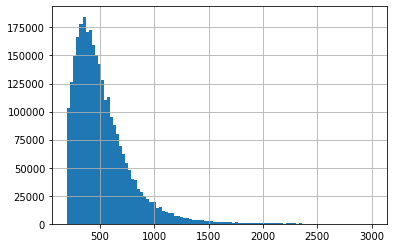

Using categorical_feature in Dataset.


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.176022 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5932
[LightGBM] [Info] Number of data points in the train set: 2926580, number of used features: 45


Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.


[LightGBM] [Info] Start training from score 524.640869
Training until validation scores don't improve for 500 rounds
[50]	valid_0's huber: 79.5819
[100]	valid_0's huber: 64.8661
[150]	valid_0's huber: 58.5516
[200]	valid_0's huber: 54.863
[250]	valid_0's huber: 52.55
[300]	valid_0's huber: 50.8421
[350]	valid_0's huber: 49.4327
[400]	valid_0's huber: 48.3986
[450]	valid_0's huber: 47.4557
[500]	valid_0's huber: 46.6475
[550]	valid_0's huber: 45.9366
[600]	valid_0's huber: 45.3064
[650]	valid_0's huber: 44.7755
[700]	valid_0's huber: 44.2752
[750]	valid_0's huber: 43.7327
[800]	valid_0's huber: 43.3043
[850]	valid_0's huber: 42.9196
[900]	valid_0's huber: 42.5725
[950]	valid_0's huber: 42.2338
[1000]	valid_0's huber: 41.9283
[1050]	valid_0's huber: 41.6296
[1100]	valid_0's huber: 41.3262
[1150]	valid_0's huber: 41.0569
[1200]	valid_0's huber: 40.8344
[1250]	valid_0's huber: 40.627
[1300]	valid_0's huber: 40.4163
[1350]	valid_0's huber: 40.1759
[1400]	valid_0's huber: 39.9657
[1450]	vali

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).


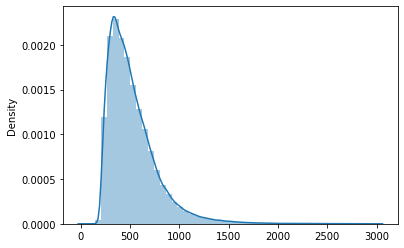

Fold 0 end
Fold 1 start
(2926581, 45)
y dist plot


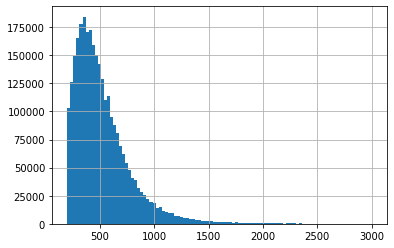

Using categorical_feature in Dataset.


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.164257 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5933
[LightGBM] [Info] Number of data points in the train set: 2926581, number of used features: 45


Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.


[LightGBM] [Info] Start training from score 524.755320
Training until validation scores don't improve for 500 rounds
[50]	valid_0's huber: 79.6868
[100]	valid_0's huber: 64.8714
[150]	valid_0's huber: 58.6927
[200]	valid_0's huber: 54.9226
[250]	valid_0's huber: 52.3593
[300]	valid_0's huber: 50.7634
[350]	valid_0's huber: 49.3364
[400]	valid_0's huber: 48.2363
[450]	valid_0's huber: 47.3739
[500]	valid_0's huber: 46.6165
[550]	valid_0's huber: 45.9686
[600]	valid_0's huber: 45.3324
[650]	valid_0's huber: 44.6054
[700]	valid_0's huber: 44.0466
[750]	valid_0's huber: 43.4995
[800]	valid_0's huber: 43.095
[850]	valid_0's huber: 42.7134
[900]	valid_0's huber: 42.3782
[950]	valid_0's huber: 42.008
[1000]	valid_0's huber: 41.7139
[1050]	valid_0's huber: 41.406
[1100]	valid_0's huber: 41.1061
[1150]	valid_0's huber: 40.8335
[1200]	valid_0's huber: 40.6255
[1250]	valid_0's huber: 40.397
[1300]	valid_0's huber: 40.2078
[1350]	valid_0's huber: 40.0162
[1400]	valid_0's huber: 39.8172
[1450]	vali

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).


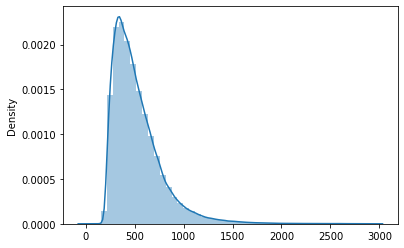

Fold 1 end
Fold 2 start
(2926581, 45)
y dist plot


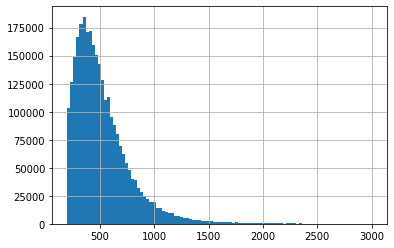

Using categorical_feature in Dataset.


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.154896 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5935
[LightGBM] [Info] Number of data points in the train set: 2926581, number of used features: 45


Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.


[LightGBM] [Info] Start training from score 524.648130
Training until validation scores don't improve for 500 rounds
[50]	valid_0's huber: 79.481
[100]	valid_0's huber: 64.6639
[150]	valid_0's huber: 58.6296
[200]	valid_0's huber: 54.8825
[250]	valid_0's huber: 52.3501
[300]	valid_0's huber: 50.5901
[350]	valid_0's huber: 49.2596
[400]	valid_0's huber: 48.1555
[450]	valid_0's huber: 47.3302
[500]	valid_0's huber: 46.5229
[550]	valid_0's huber: 45.8901
[600]	valid_0's huber: 45.2286
[650]	valid_0's huber: 44.6483
[700]	valid_0's huber: 44.0877
[750]	valid_0's huber: 43.6674
[800]	valid_0's huber: 43.2379
[850]	valid_0's huber: 42.8118
[900]	valid_0's huber: 42.4047
[950]	valid_0's huber: 42.068
[1000]	valid_0's huber: 41.7261
[1050]	valid_0's huber: 41.4114
[1100]	valid_0's huber: 41.1556
[1150]	valid_0's huber: 40.8886
[1200]	valid_0's huber: 40.6525
[1250]	valid_0's huber: 40.4122
[1300]	valid_0's huber: 40.1742
[1350]	valid_0's huber: 39.955
[1400]	valid_0's huber: 39.7495
[1450]	val

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).


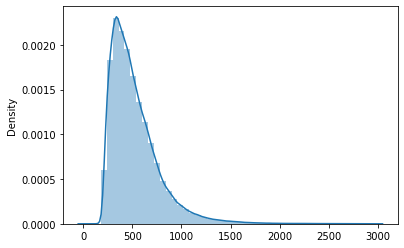

Fold 2 end
Fold 3 start
(2926581, 45)
y dist plot


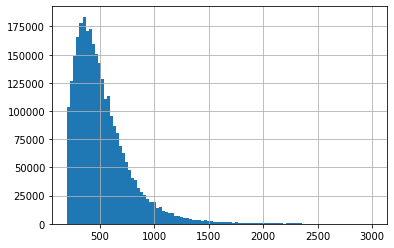

Using categorical_feature in Dataset.


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.148633 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5929
[LightGBM] [Info] Number of data points in the train set: 2926581, number of used features: 45


Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.


[LightGBM] [Info] Start training from score 524.732369
Training until validation scores don't improve for 500 rounds
[50]	valid_0's huber: 79.5235
[100]	valid_0's huber: 64.7284
[150]	valid_0's huber: 58.64
[200]	valid_0's huber: 54.9724
[250]	valid_0's huber: 52.579
[300]	valid_0's huber: 50.7487
[350]	valid_0's huber: 49.3852
[400]	valid_0's huber: 48.3254
[450]	valid_0's huber: 47.3401
[500]	valid_0's huber: 46.5588
[550]	valid_0's huber: 45.831
[600]	valid_0's huber: 45.2301
[650]	valid_0's huber: 44.6829
[700]	valid_0's huber: 44.1607
[750]	valid_0's huber: 43.7062
[800]	valid_0's huber: 43.2695
[850]	valid_0's huber: 42.8401
[900]	valid_0's huber: 42.4812
[950]	valid_0's huber: 42.1
[1000]	valid_0's huber: 41.7615
[1050]	valid_0's huber: 41.4538
[1100]	valid_0's huber: 41.1671
[1150]	valid_0's huber: 40.8931
[1200]	valid_0's huber: 40.6658
[1250]	valid_0's huber: 40.444
[1300]	valid_0's huber: 40.2343
[1350]	valid_0's huber: 40.007
[1400]	valid_0's huber: 39.8309
[1450]	valid_0's

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).


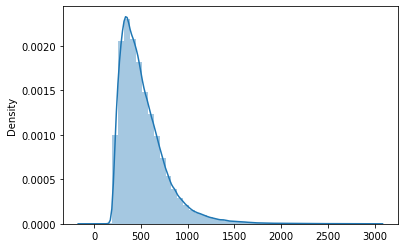

Fold 3 end
Fold 4 start
(2926581, 45)
y dist plot


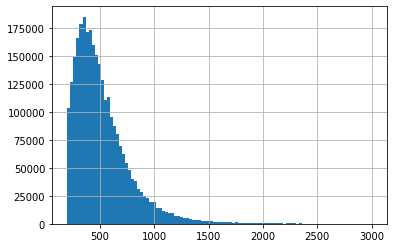

Using categorical_feature in Dataset.


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.151196 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5930
[LightGBM] [Info] Number of data points in the train set: 2926581, number of used features: 45


Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.


[LightGBM] [Info] Start training from score 524.646665
Training until validation scores don't improve for 500 rounds
[50]	valid_0's huber: 79.4209
[100]	valid_0's huber: 64.789
[150]	valid_0's huber: 58.7974
[200]	valid_0's huber: 55.0505
[250]	valid_0's huber: 52.7123
[300]	valid_0's huber: 50.9609
[350]	valid_0's huber: 49.5613
[400]	valid_0's huber: 48.5767
[450]	valid_0's huber: 47.473
[500]	valid_0's huber: 46.7036
[550]	valid_0's huber: 45.9384
[600]	valid_0's huber: 45.2514
[650]	valid_0's huber: 44.6544
[700]	valid_0's huber: 44.1154
[750]	valid_0's huber: 43.6165
[800]	valid_0's huber: 43.1863
[850]	valid_0's huber: 42.7673
[900]	valid_0's huber: 42.4117
[950]	valid_0's huber: 42.0746
[1000]	valid_0's huber: 41.7578
[1050]	valid_0's huber: 41.4507
[1100]	valid_0's huber: 41.1737
[1150]	valid_0's huber: 40.9223
[1200]	valid_0's huber: 40.6982
[1250]	valid_0's huber: 40.4868
[1300]	valid_0's huber: 40.2626
[1350]	valid_0's huber: 40.0883
[1400]	valid_0's huber: 39.8819
[1450]	va

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).


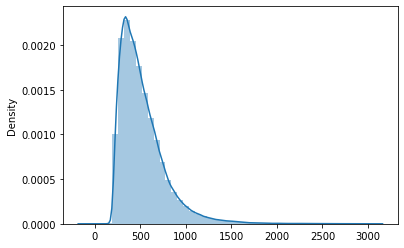

Fold 4 end


<Figure size 432x288 with 0 Axes>

In [25]:
count = 0
oof = np.zeros(training_data_df.shape[0])

shap_summary_df = pd.DataFrame()

for train_idx, val_idx in kf.split(training_data_df):
    print('Fold {} start'.format(count))
    train_data = training_data_df.loc[train_idx]
    val_data = training_data_df.loc[val_idx]
    
    x_train = train_data.drop(columns=target_cols)
    y_train = train_data['가격면적']
    
    print(x_train.shape)
    
    x_val = val_data.drop(columns=target_cols)
    y_val = val_data['가격면적']
    
    print('y dist plot')
    y_train.hist(bins=100)
    plt.show()
    plt.clf()
    
    params = {
        'objective': 'huber',
        'learning_rate': 10,
        'seed': 42,
        'max_depth': 12,
        'num_leaves': 37,
        'lambda_l2': 0,
        'metric': 'huber',
        'num_threads': 6,
    }
    
    train_dataset = lgb.Dataset(x_train, label=y_train, categorical_feature=cat_cols)
    val_dataset = lgb.Dataset(x_val, label=y_val, categorical_feature=cat_cols)
    
    num_rounds = 10000

    bst = lgb.train(params, train_dataset, num_rounds, valid_sets=[val_dataset], early_stopping_rounds=500, verbose_eval=50)
    
    bst.save_model(basedir + 'lightgbm_huber_shap_top_45_{}.txt'.format(count), num_iteration=bst.best_iteration)
    
    preds = bst.predict(x_val, num_iteration=bst.best_iteration)
    
    print('preds dist plot')
    sns.distplot(preds)
    plt.show()
    plt.clf()
    
    oof[val_idx] = preds
    
    # shap
    explainer = shap.explainers.Tree(bst)
    
    sample_x = x_val.sample(n=1000)
    sample_y = y_val.loc[sample_x.index]
    
    shap_values = explainer.shap_values(sample_x, y=sample_y, check_additivity=True, approximate=False)
    shap_values_T = shap_values.T
    
    shap_summary = np.zeros(x_val.shape[1])
    
    for i in range(x_val.shape[1]):
        shap_summary[i] = np.mean(np.abs(shap_values_T[i]))
    
    
    shap_summary_df['model_{}_shap_summary'.format(count)] = shap_summary
        
    
    print('Fold {} end'.format(count))
    count += 1

In [26]:
from sklearn.metrics import mean_squared_error

In [27]:
np.sqrt(mean_squared_error(training_data_df['가격면적'], oof))

65.25860762273588

In [28]:
shap_summary_mean = np.zeros(shap_summary_df.shape[0])
for i in range(shap_summary_df.shape[1]):
    shap_summary_mean += shap_summary_df.iloc[:,i]

In [29]:
shap_summary_mean = shap_summary_mean / shap_summary_df.shape[1]

In [30]:
shap_summary_df['shap_summary_mean'] = shap_summary_mean

In [31]:
shap_summary_df.index = x_train.columns

In [32]:
shap_summary_df.to_csv(basedir + 'shap_top_45.csv')

In [33]:
shap_summary_df.head(10)

,model_0_shap_summary,model_1_shap_summary,model_2_shap_summary,model_3_shap_summary,model_4_shap_summary,shap_summary_mean
trade_type,94.544142,93.736138,92.205033,94.799576,94.476787,93.952335
공시지가(만원),75.693267,77.992167,76.293766,77.415995,81.337172,77.746473
year_linear,64.345777,65.954926,62.499814,63.805882,65.183594,64.357999
건축년도,47.427376,46.097969,45.861742,47.963608,48.121648,47.094468
전용면적,40.084776,35.712764,37.732474,35.497766,38.859649,37.577486
ynorm,31.586869,31.023605,30.970457,31.102520,30.698971,31.076484
xy,23.870775,21.066993,21.420318,22.807127,22.478437,22.328730
x_2nd,18.709031,19.346512,19.691544,20.575816,19.923733,19.649327
주건축물수,14.456543,12.955188,13.557963,13.472946,14.560911,13.800710
층mean,10.952284,10.225442,9.948209,12.713209,11.218072,11.011443


In [34]:
shap_summary_df.tail(10)

,model_0_shap_summary,model_1_shap_summary,model_2_shap_summary,model_3_shap_summary,model_4_shap_summary,shap_summary_mean
(한강)폐기물매립시설_설치제한지역,2.092373,2.115897,1.982099,2.208178,2.128095,2.105328
지형형상,1.502488,1.313797,1.293210,1.570355,1.400896,1.416149
y_sin,1.418796,1.329772,1.144686,1.257045,1.264644,1.282989
y_cos,1.239585,1.267534,1.215918,1.182417,1.190358,1.219162
x_sin,1.336861,1.194599,1.330512,1.339432,1.220136,1.284308
x_cos,1.331125,1.136524,1.250915,1.231846,1.295311,1.249144
상대정화구역,1.000238,1.066041,1.073812,0.877972,1.204620,1.044536
정비구역,1.216269,1.124314,1.020622,0.999150,1.184868,1.109045
제3종일반주거지역,1.279595,1.054778,1.157858,1.005870,1.040436,1.107707
제1종지구단위계획구역,1.064373,1.237431,1.091574,1.092669,0.928687,1.082947


In [ ]:
#